## Deep Learning – Assignment 2 – 2023 ##


## Harshith Hullakere Siddegowda
## s3914263



## Introduction
The project aims to develop a end to end deep learning model for stance classification in tweets, focusing on five politically-charged target topics: "Atheism," "the Feminist Movement," "Climate Change is a Real Concern," "Legalization of Abortion," and "Hillary Clinton." The primary goal is to classify tweets into one of three categories: FAVOR, AGAINST, or NEITHER, indicating whether the tweet expresses support, opposition, or neither toward the specified target topic.
Challenges:
1. Ambiguity: Some tweets may not explicitly express support or opposition.
2. Context Dependency: Stance can be context-dependent and may vary across topics.
3. Data Imbalance: The dataset may have an uneven distribution of stances and topics.

Given the text of a tweet and a target, models must classify the tweet as either FAVOUR or AGAINST,
or NEITHER (if the tweet does not express support or opposition to the target topic).


Function to be loaded for Data augmentation cleaning

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, test_generator):
    predictions = []  # List to store predicted labels
    true_labels = []   # List to store true labels

    # Iterate through the test generator to obtain predictions
    for x, y_true in test_generator:
        # Access the 'tweet' and 'target' inputs
        tweet_input = x['tweet']
        target_input = x['target']

        # Predict using your model
        y_pred = model.predict({'tweet': tweet_input, 'target': target_input})

        # Convert predicted probabilities to class labels (e.g., using argmax)
        # Assuming y_pred is an array of shape (batch_size, num_classes)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Append predicted labels and true labels to the lists
        predictions.extend(y_pred_labels)
        true_labels.extend(np.argmax(y_true, axis=1))  # Convert one-hot to class labels

    # Calculate evaluation metrics
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    f1_macro = f1_score(true_labels, predictions, average='macro')
    report = classification_report(true_labels, predictions)# Calculate confusion matrix
    confusion_mat = confusion_matrix(true_labels, predictions)

    return {
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'classification_report': report,
        'confusion_matrix': confusion_mat
    }


In [1]:
from tensorflow import keras
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
import string
from nltk.corpus import stopwords


def create_dataset(dataframe, batch_size, shuffle_buffer_size=None):
    # Extract columns
    A_tweet = dataframe['Tweet'].values.tolist()
    target = dataframe['Target'].values
    category = dataframe['Stance'].values

    # Text Cleaning
    def clean_text(text):
        # Remove emojis
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
        text = re.sub(r'[:=;][oO\-]?[D\)\]\(\]/\\OpP]', '', text)  # Remove common emojis

        # Remove Url's
        text = re.sub(r'http\S+', '', text)

        #Remove '#' and '@' symobls
        text = text.replace('#', '').replace('@', '')

        # Tokenize the text
        tokens = word_tokenize(text)

        # Convert to lower case
        tokens = [w.lower() for w in tokens]

        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table) for w in tokens]

        # Remove non-alphanumeric characters
        words = [word for word in words if word.isalpha()]

        cleaned_text = ' '.join(words)

        return cleaned_text

    # Clean the text in A_tweet
    cleaned_tweets = [clean_text(text) for text in A_tweet]

    # Create a DataFrame with cleaned data
    cleaned_df = pd.DataFrame({
        'Tweet': cleaned_tweets,
        'Target': target,
        'Stance': category
    })

    return cleaned_df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Setting and Loading Dataset



In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

<IPython.core.display.Javascript object>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os


new_directory = '/content/drive/MyDrive/COSC2779/Sassignment/StanceDataset'
os.chdir(new_directory)

In [6]:
import csv

data = []

with open('train.csv', 'r', encoding='ISO-8859-1') as file:
    csv_reader = csv.reader(file, delimiter=',', quotechar='"')
    for line_number, row in enumerate(csv_reader):
        try:
            # Process the row and append it to the data list
            data.append(row)
        except Exception as e:
            # Handle any exceptions or errors encountered during processing
            print(f"Error processing line {line_number}: {e}")


df = pd.DataFrame(data[1:], columns=data[0])
df

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [7]:
df = pd.read_csv('train.csv', sep=',', encoding='unicode_escape', engine="python")
df

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [8]:
df_test = pd.read_csv('test.csv', sep=',', encoding='unicode_escape', engine="python")
df_test

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
...,...,...,...,...,...
1244,@MetalheadMonty @tom_six I followed him before...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
1245,"For he who avenges blood remembers, he does no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,other
1246,Life is sacred on all levels. Abortion does no...,Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,other
1247,"@ravensymone U refer to ""WE"" which =""YOU"" & a ...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg


## Exploratory Data Analysis

Exploratory Data Analysis (EDA):
EDA phase,I have made several noteworthy observations: Stance Distribution: The dataset exhibits an imbalance, with "AGAINST" being the most prevalent stance (1395 instances), followed by "NONE" (766) and "FAVOR" (753).Target Distribution: The target topics are almost evenly distributed across all tweets, indicating a balanced representation of political instances.Sentimental Analysis: Sentiment labels, including negative (1762 instances), positive (963 instances), and other (189 instances), provide an insight into the overall sentiment of tweets in the dataset.Target Distribution with Stance Categories: Specific patterns emerge within different stance categories:
1. "AGAINST" stance has minimal representation (less than 4%) related to the "Climate Change is a Real Concern" target.
2. "FAVOR" stance has significantly fewer instances compared to the "AGAINST" stance, with a nearly 50% reduction.
3. The "NONE" stance is roughly equally represented as the "FAVOR" stance, indicating that it has fewer instances compared to "AGAINST."

Word Cloud Analysis: For each political target stance, I have created word clouds to visualize word frequencies in tweets related to specific topics. Each word cloud was generated to capture the unique vocabulary associated with these topics. This analysis can offer valuable insights into the language and discourse surrounding these topics on social media, helping to inform further data preprocessing and model development efforts.


In [9]:
df['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

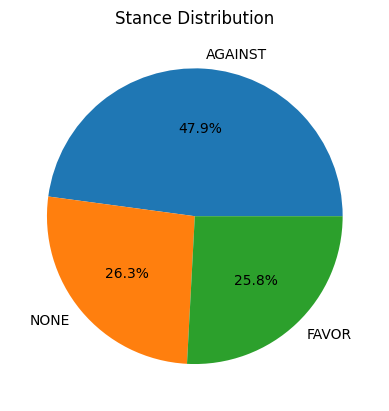

In [10]:
stance_counts = df['Stance'].value_counts()
plt.pie(stance_counts, labels=stance_counts.index, autopct='%1.1f%%')
plt.title('Stance Distribution')
plt.show()

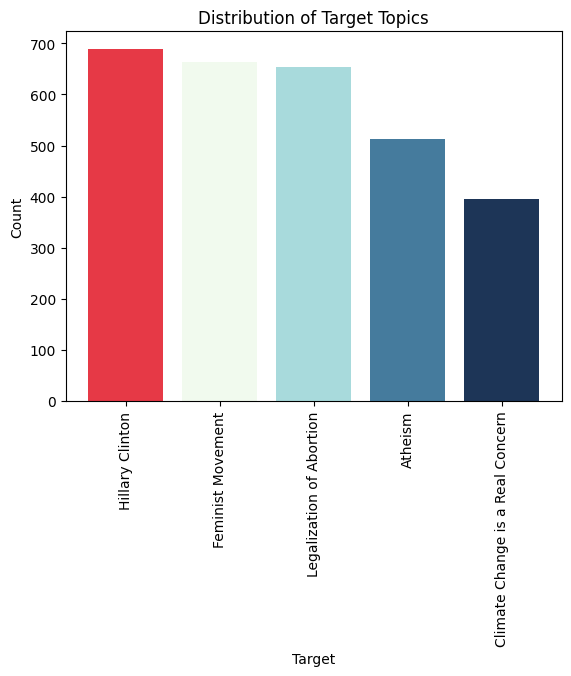

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn

target_counts = df['Target'].value_counts()

custom_colors = ["#E63946", "#F1FAEE", "#A8DADC", "#457B9D", "#1D3557"]
colors = custom_colors[:len(target_counts)]

plt.bar(target_counts.index, target_counts.values, color=colors)  # Assign colors
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Topics')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


In [12]:
df['Sentiment'].value_counts()

neg      1762
pos       963
other     189
Name: Sentiment, dtype: int64

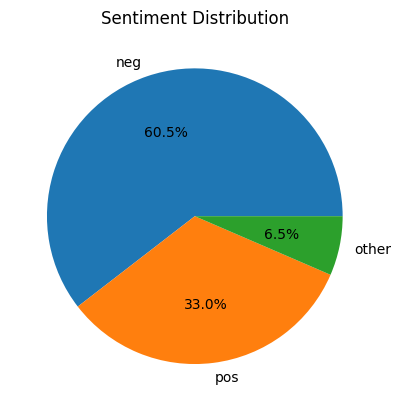

In [13]:
sentiment_counts = df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

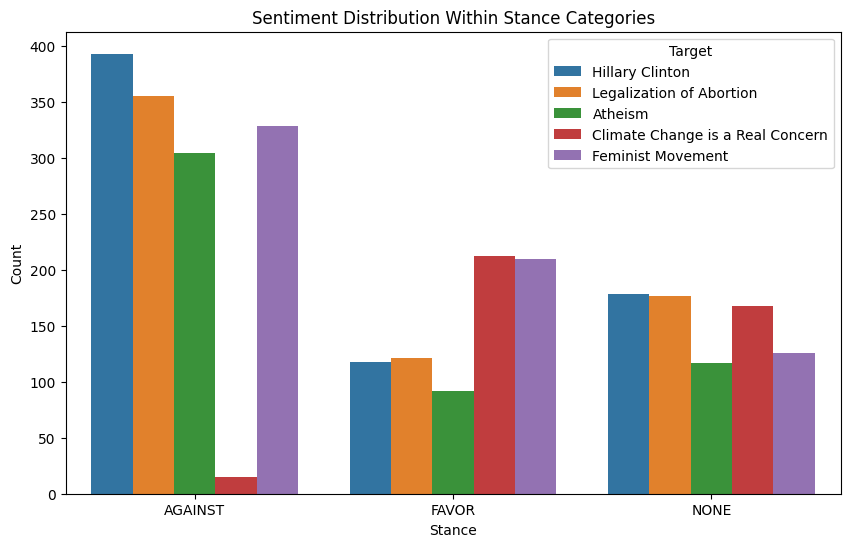

In [14]:
import seaborn as sns

# Create a bar plot to visualize sentiment distribution within each stance
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stance', hue='Target')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.title('Sentiment Distribution Within Stance Categories')
plt.legend(title='Target', loc='upper right')
plt.show()


In [15]:
def make_word_cloud(string):
  word_cloud = WordCloud(background_color ="white", max_words=59, stopwords=set(STOPWORDS)).generate(string)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Word Cloud For the target political stance: Hillary Clinton




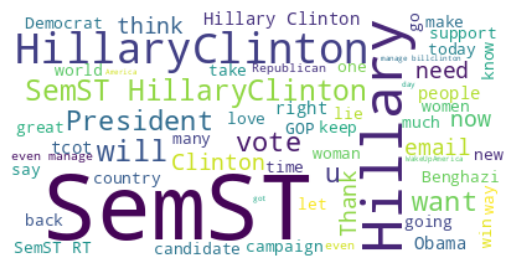



Word Cloud For the target political stance: Legalization of Abortion




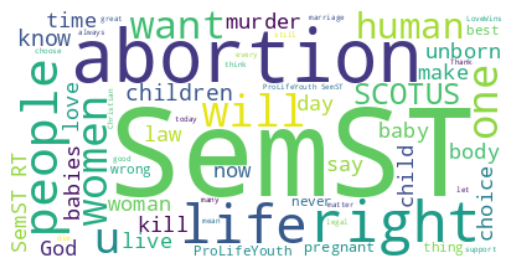



Word Cloud For the target political stance: Atheism




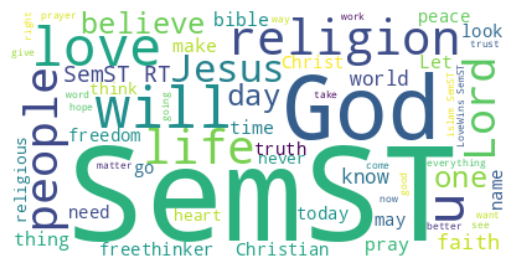



Word Cloud For the target political stance: Climate Change is a Real Concern




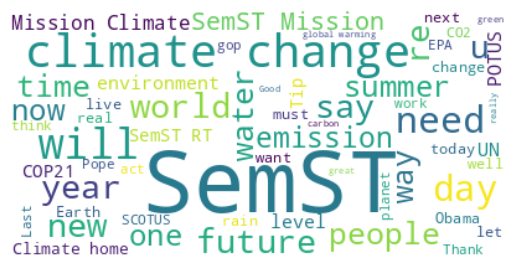



Word Cloud For the target political stance: Feminist Movement




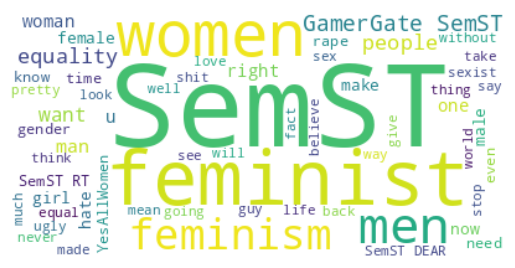

In [16]:
from wordcloud import WordCloud, STOPWORDS

target_values = df['Target'].unique()
for values in target_values:
  target_values = df.loc[df['Target']==values]
  All_target_values = " ".join(target_values.Tweet.values)
  print("Word Cloud For the target political stance:", values)
  print("\n")
  make_word_cloud(All_target_values)
  print("\n")

## Plot

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_smoothed_metrics(history):
    """
    Plot smoothed training and validation loss and accuracy curves.

    Args:
        history: History object returned by model.fit().
    """
    # Define colors and line styles
    colors = ['r', 'c', 'y', 'k']
    line_styles = ['-', '--', '-.', ':']

    # Define the number of points for interpolation
    num_points = 300

    # Create smoothed epochs using interpolation
    epochs = np.linspace(1, len(history.history['loss']), num_points)

    # Extract the training and validation metrics from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Interpolate training and validation loss
    spline = make_interp_spline(range(1, len(train_loss) + 1), train_loss)
    smooth_train_loss = spline(epochs)

    spline = make_interp_spline(range(1, len(val_loss) + 1), val_loss)
    smooth_val_loss = spline(epochs)

    # Interpolate training and validation accuracy
    spline = make_interp_spline(range(1, len(train_accuracy) + 1), train_accuracy)
    smooth_train_accuracy = spline(epochs)

    spline = make_interp_spline(range(1, len(val_accuracy) + 1), val_accuracy)
    smooth_val_accuracy = spline(epochs)

    # Create subplots
    plt.figure(figsize=(12, 4))

    # Plot smoothed training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, smooth_train_loss, label='Smoothed Training Loss', color=colors[0], linestyle=line_styles[0])
    plt.plot(epochs, smooth_val_loss, label='Smoothed Validation Loss', color=colors[1], linestyle=line_styles[1])
    plt.title('Smoothed Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot smoothed training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, smooth_train_accuracy, label='Smoothed Training Accuracy', color=colors[2], linestyle=line_styles[2])
    plt.plot(epochs, smooth_val_accuracy, label='Smoothed Validation Accuracy', color=colors[3], linestyle=line_styles[3])
    plt.title('Smoothed Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


In [ ]:
# .Given the text of a
# tweet and a target, models must classify the tweet as either FAVOUR or AGAINST,
# or NEITHER (if the tweet does not express support or opposition to the target topic).

## Data Loader and Data Split


Data Loader(Data Generator Class) and NLP Cleaning:

In the Data Loader and NLP cleaning process, I have created a versatile data generator class, known as DataGenerator, to facilitate the efficient loading and preprocessing of text data for our stance classification project. This class is designed to work seamlessly with TensorFlow and provides a systematic approach to handling the complexities of text data.


In [10]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [11]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing tweet data

# Stratified split based on 'target' and 'stance' columns
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df[['Target', 'Stance']], random_state=42)
print(train_df['Target'].unique())
print("\n")
print(train_df['Stance'].unique())
print("\n")
print(train_df['Target'].value_counts())
print("\n")
print(train_df['Stance'].value_counts())
train_df

['Hillary Clinton' 'Climate Change is a Real Concern' 'Atheism'
 'Legalization of Abortion' 'Feminist Movement']


['AGAINST' 'FAVOR' 'NONE']


Hillary Clinton                     550
Feminist Movement                   531
Legalization of Abortion            523
Atheism                             411
Climate Change is a Real Concern    316
Name: Target, dtype: int64


AGAINST    1115
NONE        613
FAVOR       603
Name: Stance, dtype: int64


,Tweet,Target,Stance,Opinion Towards,Sentiment
2201,Those aren't pantsuits. They are camouflage ou...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
666,So #Christian s... Without beaches what is yo...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
1970,@BuffaloBill71 @AramisFraino @pamnsc Thank yo...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,pos
772,The last thing #Australia or the world needs a...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
357,Most people need love and acceptance a lot mor...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
...,...,...,...,...,...
1425,@marieclaire Or...She's a grown 21st century w...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2769,Another SCOTUS decision I do not agree with. I...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
2512,Re Last: I can't get past this...why must abor...,Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
852,"#AskRobertRedford Beyond the national level, w...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,other


#### NLP cleaning



The NLP text preprocessing includes tasks such as cleaning text by removing extra whitespaces, emojis, URLs, and special characters. It also involves tokenization, converting text to lowercase, and eliminating punctuation and non-alphanumeric characters However, I Am not removing stop words because it loses the context of the sentence.


Moreover, it's worth noting that when the DataGenerator generates batches, the shape of the data it provides is as follows: Tweet Shape: (32,), Target Shape: (32,), and Stance Shape: (32, 3).

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [58]:
from tensorflow import keras
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import tensorflow as tf
import re
import string
from nltk.tokenize import word_tokenize

class DataGenerator(tf.keras.utils.Sequence):
    'Generate data from Keras'

    def __init__(self, data_frame, batch_size=32, n_classes=3, shuffle=True, max_sequence_length=128):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.A_tweet = data_frame['Tweet'].values.tolist()
        self.target = data_frame['Target'].values
        self.category = data_frame['Stance'].values
        self.n_classes = n_classes

        # Initialize tokenizer
        self.max_sequence_length = max_sequence_length
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.A_tweet)
        self.encode_stance = {
            "FAVOR": 1,
            "AGAINST": 2,
            "NONE": 0
        }


        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.A_tweet)) / self.batch_size)

    def on_epoch_end(self):
        'Indexes after each epoch'
        self.indexes = np.arange(len(self.A_tweet))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        tweet = [self.preprocess_text(self.A_tweet[i]) for i in indexes]
        target = [self.target[i] for i in indexes]
        stance = [self.encode_stance[self.category[i]] for i in indexes]

        n_values = np.max(stance) + 1
        Y = np.eye(n_values)[stance]

        # Convert text data to a TensorFlow tensor of strings
        text_tensor = tf.convert_to_tensor(tweet, dtype=tf.string)

        target_tensor = tf.convert_to_tensor(target, dtype=tf.string)

        # Convert stance labels to a TensorFlow tensor of floats
        stance_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)

        return {'tweet': text_tensor, 'target': target_tensor}, stance_tensor

    def preprocess_text(self, text):
        cleaned_text = self.clean_text(text)
        sequence = self.tokenizer.texts_to_sequences([cleaned_text])[0]
        padded_sequence = pad_sequences([sequence], maxlen=self.max_sequence_length, padding='post')[0]
        return cleaned_text

    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
        text = re.sub(r'[:=;][oO\-]?[D\)\]\(\]/\\OpP]', '', text)  # Remove common emojis

        # Remove Url's
        text = re.sub(r'http\S+', '', text)

        #Remove '#' and '@' symobls
        text = text.replace('#', '').replace('@', '')

        text= re.sub("rt", " ", text)
        text= re.sub("fav", "", text)

        # Tokenize the text
        tokens = word_tokenize(text)

        # Convert to lower case
        tokens = [w.lower() for w in tokens]

        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table) for w in tokens]

        # Remove non-alphanumeric characters
        words = [word for word in words if word.isalpha()]

        cleaned_text = ' '.join(words)

        return cleaned_text

In [79]:
batch_size=32
# max_sequence_length = 50
training_generator = DataGenerator(train_df, batch_size=batch_size, n_classes=3, shuffle = True)
validation_generator =DataGenerator(val_df, batch_size=batch_size, n_classes=3, shuffle = True)

In [60]:
for batch in training_generator:
  x, y = batch
  tweet_shape = x['tweet'].shape
  target_shape = x['target'].shape
  stance_shape = y.shape

  print(f'Tweet Shape: {tweet_shape}, Target Shape: {target_shape}, Stance Shape: {stance_shape}')


Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: 

In [17]:
test_generator = DataGenerator(df_test, batch_size=batch_size, n_classes=3, shuffle = True)

In [78]:
for batch in test_generator:
  x, y = batch
  tweet_shape = x['tweet'].shape
  target_shape = x['target'].shape
  stance_shape = y.shape

  print(f'Tweet Shape: {tweet_shape}, Target Shape: {target_shape}, Stance Shape: {stance_shape}')


Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: 

## No DataLoader

In [20]:
import string
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

def create__dataset(dataframe, batch_size, shuffle_buffer_size=None):
    A_tweet = dataframe['Tweet'].values.tolist()
    target = dataframe['Target'].values
    category = dataframe['Stance'].values

    # Text Cleaning
    def clean_text(text):
        # Remove emojis
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
        text = re.sub(r'[:=;][oO\-]?[D\)\]\(\]/\\OpP]', '', text)  # Remove common emojis

        # Remove Url's
        text = re.sub(r'http\S+', '', text)

        #Remove '#' and '@' symobls
        text = text.replace('#', '').replace('@', '')

        # Tokenize the text
        tokens = word_tokenize(text)

        # Convert to lower case
        tokens = [w.lower() for w in tokens]

        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table) for w in tokens]

        # Remove non-alphanumeric characters
        words = [word for word in words if word.isalpha()]

        return words

    A_tweet = [clean_text(text) for text in A_tweet]
    print(A_tweet[0:2])

    tokenizer_obj = Tokenizer()
    tokenizer_obj.fit_on_texts(A_tweet)
    sequences = tokenizer_obj.texts_to_sequences(A_tweet)

    word_index = tokenizer_obj.word_index
    print('unique tokens - ' + str(len(word_index)))
    vocab_size = len(tokenizer_obj.word_index) + 1
    print('vocab_size - ' + str(vocab_size))

    # Decide on an appropriate maximum sequence length and set maxlen in pad_sequences.
    max_sequence_length = 50  # Example: set an appropriate value based on your data
    lines_pad = pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

    # return lines_pad, target, category
    return lines_pad, target, category

In [ ]:
validation_split=0.20
BATCH_SIZE = 32


lines_pad, target, stance_category = create__dataset(df, batch_size=BATCH_SIZE, shuffle_buffer_size=len(df))
print(lines_pad)
print(target)
print(stance_category)


[['tedcruz', 'and', 'handovertheserver', 'she', 'wiped', 'clean', 'deleted', 'emails', 'explains', 'dereliction', 'of', 'dutylies', 're', 'benghazi', 'etc', 'tcot'], ['hillary', 'is', 'our', 'best', 'choice', 'if', 'we', 'truly', 'want', 'to', 'continue', 'being', 'a', 'progressive', 'nation', 'ohio']]
unique tokens - 8798
vocab_size - 8799
[[ 842    9 3208 ...    0    0    0]
 [  42    5   68 ...    0    0    0]
 [3212    7   94 ...    0    0    0]
 ...
 [  50 1254    8 ...    0    0    0]
 [ 152  108   11 ...    0    0    0]
 [ 150 8794  116 ...    0    0    0]]
['Hillary Clinton' 'Hillary Clinton' 'Hillary Clinton' ...
 'Legalization of Abortion' 'Legalization of Abortion'
 'Legalization of Abortion']
[2 1 2 ... 2 2 2]


Split the dataset in to train and validation

In [ ]:
# indices = np.arange(lines_pad.shape[0])
# np.random.shuffle(indices)
# lines_pad = lines_pad[indices]
# target = target[indices]
# stance_category = stance_category[indices]


# #one hot encoding
# stance_n_values = np.max(stance_category)+1
# Y_stance = np.eye(stance_n_values)[stance_category]

# num_validation_samples = int(validation_split*lines_pad.shape[0])

# A_train_pad = lines_pad[:-num_validation_samples]
# Y_train_target = Y_target[:-num_validation_samples]
# Y_train = Y_stance[:-num_validation_samples]

# A_val_pad = lines_pad[-num_validation_samples:]
# Y_val_target = Y_target[-num_validation_samples:]
# Y_val = Y_stance[-num_validation_samples:]


# print('Shape of A_train_pad:',A_train_pad.shape)
# print('Shape of Y_train_target:',Y_train_target.shape)
# print('shape of Y_train:',Y_train.shape)


# print( 'Shape of A_val_pad:',A_val_pad.shape)
# print('shape of Y_val_target:',Y_val_target.shape)
# print('shape Y_val_target:', Y_val.shape)


## Loading the model from TensorFlow Hub

## Classifier Model

Why I have selected the BERT models rather than other embeddings is, with their bidirectional contextual understanding, pre-trained knowledge, fine-tuning capabilities, and a range of available architectures, make them a compelling choice for NLP tasks, such as political stance classification in tweets. These models have proven successful in a wide array of NLP applications and continue to be at the forefront of natural language understanding technology.


Baseline Model Architecture: The baseline classifier model: I am using a Small BERT model as a core component to experiment initially, which offers a balance between model size, speed, and quality. They are particularly suitable for real-world applications where efficient resource usage and fast inference times and they are essential capabilities. It features an architecture with two input layers for tweet and target text, followed by preprocessing layers to tokenize and preprocess the text data. The BERT encoder extracts contextual embeddings, and the concatenated outputs capture the relationship between the tweet and target text.Secondly, added Dropout Layer A dropout layer with a 0.1 dropout rate is included to reduce overfitting and improve generalization.added, Classifier Layer The model utilizes a dense layer with softmax activation for multi-class classification into "FAVOR," "AGAINST," or "NONE."added, Regularization L2 regularization with random value of 0.00001 is applied to the classifier layer to control overfitting, encouraging smaller weights for better generalization.


In [19]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

!pip install -q tf-models-official

import os
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

#### BERT Embedding

In [20]:
bert_model_name = "talking-heads_base"
map_name_to_handle = {'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
                      }

map_model_to_preprocess = {'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',

}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected: {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected : {tfhub_handle_preprocess}')

BERT model selected: https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Preprocess model auto-selected : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [25]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [26]:
text_test = ['dalydegagne canada alone needs invest billion a year paid for by efficiency cdnpoli environment semst', 'cooimemegirl tcstompa you have no respect for real equality so you lie and claim feminists want it semst', 'as you follow me i lead you along paths of newness ways you have never imagined jesuscalling semst', 'nothing says i m every woman like democrat staffers in a machine shop in iowa right hillaryclinton notreadyforhillary semst', 'rt pleasesavetrees for our own survival to fight saveourplanet semst', 'someone snitched on the mom having sex with and playing naked twister with teens i bet it was her cock blocking ass children semst']

text_test_strings = [' '.join(tokens) for tokens in text_test]

# Preprocess the text using the BERT preprocessing model
text_preprocessed = bert_preprocess_model(text_test_strings)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (6, 128)
Word Ids   : [ 101 1040 1037 1048 1061 1040 1041 1043 1037 1043 1050 1041]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(6, 512)
Pooled Outputs Values:[ 0.8925172  -0.6058863   0.3079682  -0.08872524  0.5615828   0.9853495
  0.9834267  -0.89540106 -0.13548353 -0.9777458   0.17219923  0.10820503]
Sequence Outputs Shape:(6, 128, 512)
Sequence Outputs Values:[[ 0.62316203 -0.38423237 -0.30345574 ... -0.3565879   0.04161733
  -0.4858688 ]
 [ 0.31627363 -0.07481869 -0.58350873 ... -0.7836075  -1.0965168
  -0.34287775]
 [ 0.34123552 -0.05347246 -0.24160689 ... -0.42767233 -0.46222872
   0.1470018 ]
 ...
 [ 0.5622413  -0.20093349 -0.036261   ... -0.25859627  0.7764416
  -0.799682  ]
 [ 0.4661991  -0.41237086 -0.48635194 ... -0.5629946   0.23749611
  -0.51230395]
 [ 0.6388867   0.4024975   0.4554737  ... -0.5437425   0.34284586
  -0.6074873 ]]


In [29]:
import tensorflow_hub as hub
# def build_classifier_model(l2_lambda=0.01):

def build_classifier_model(l2_lambda=0.01):
  # Input Layer
  tweet_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')
  target_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='target')

  #Pre-process layers
  preprocessing_layer= hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  tweet_encoder_inputs = preprocessing_layer(tweet_input)
  target_encoder_inputs = preprocessing_layer(target_input)

  #Bert-Encoder layers
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name= 'BERT_encoder')
  tweet_outputs = encoder(tweet_encoder_inputs)
  target_outputs = encoder(target_encoder_inputs)

  #concatenated output
  net_concatenated_outputs = tf.keras.layers.concatenate([tweet_outputs['pooled_output'],target_outputs['pooled_output']], axis=-1)

  #Adding droupout layer
  net = tf.keras.layers.Dropout(0.1)(net_concatenated_outputs)

  # classifier layer.  # kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
  net = tf.keras.layers.Dense(3,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='classifier')(net)

  return tf.keras.Model(inputs=[tweet_input, target_input], outputs = net)


In [30]:
l2_lambda=0.01
classifier_model = build_classifier_model(l2_lambda=l2_lambda)

# classifier_model = build_classifier_model()

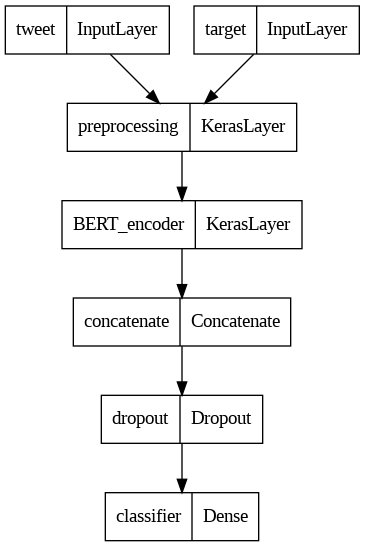

In [31]:
tf.keras.utils.plot_model(classifier_model)

In [25]:
from tensorflow.keras.optimizers import Adam, SGD
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# metrics = tf.metrics.CategoricalAccuracy()
from tensorflow.keras import metrics
epochs = 5

lr_schedule = 0.00001
optimizer = Adam(learning_rate=lr_schedule)#learning_rate=lr_schedule
classifier_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision()]
)

In [25]:
epochs = 20

In [26]:
print(f'Training model with {tfhub_handle_encoder}')
history={}
history['classifier'] = classifier_model.fit(x=training_generator,
                               validation_data=validation_generator,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/20
72/72 [==============================] - 89s 1s/step - loss: 1.0514 - accuracy: 0.5282 - val_loss: 1.0334 - val_accuracy: 0.5503
Epoch 2/20
72/72 [==============================] - 72s 997ms/step - loss: 1.0381 - accuracy: 0.5343 - val_loss: 1.0122 - val_accuracy: 0.5486
Epoch 3/20
72/72 [==============================] - 72s 998ms/step - loss: 1.0196 - accuracy: 0.5456 - val_loss: 1.0036 - val_accuracy: 0.5521
Epoch 4/20
72/72 [==============================] - 71s 995ms/step - loss: 1.0088 - accuracy: 0.5464 - val_loss: 0.9977 - val_accuracy: 0.5469
Epoch 5/20
72/72 [==============================] - 71s 993ms/step - loss: 0.9987 - accuracy: 0.5503 - val_loss: 0.9892 - val_accuracy: 0.5521
Epoch 6/20
72/72 [==============================] - 71s 994ms/step - loss: 0.9986 - accuracy: 0.5447 - val_loss: 0.9880 - val_accuracy: 0.5538
Epoch 7/20
72/72 [==============================] - 71s 994ms/ste

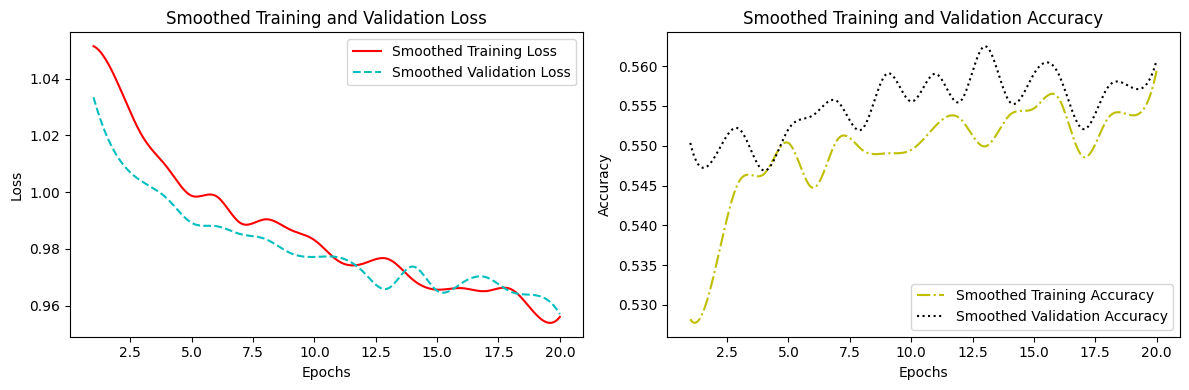

In [27]:
plot_smoothed_metrics(history['classifier'])

In [29]:
# Assuming you've already defined your test_generator and model
results = evaluate_model(classifier_model, validation_generator)

# Print the evaluation results
print("\nEvaluation Results:")
print("Precision (Weighted):", results['precision'])
print("Recall (Weighted):", results['recall'])
print("F1 (Weighted):", results['f1_weighted'])
print("F1 (Macro):", results['f1_macro'])
print("\nClassification Report:")
print(results['classification_report'])

1/1 [==============================] - 0s 456ms/step

Evaluation Results:
Precision (Weighted): 0.573370814624649
Recall (Weighted): 0.5538194444444444
F1 (Weighted): 0.46517969766710743
F1 (Macro): 0.4005069170494358

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.09      0.15       151
           1       0.61      0.25      0.35       150
           2       0.55      0.98      0.70       275

    accuracy                           0.55       576
   macro avg       0.58      0.44      0.40       576
weighted avg       0.57      0.55      0.47       576



## LSTM Model



I am  incorporating bidirectional Long Short-Term Memory (LSTM) layers, further enhancing the model's ability to capture contextual information and nuances in text. In addition to this, I leveraged the power of Google's 'talkheads_ggelu_bert_en_base' pre-trained BERT embeddings for tweet and target text processing.

In [129]:
import tensorflow as tf
import tensorflow_hub as hub

def build_classifier_modelLSTM(l2_lambda=0.01):
    # Input Layer
    tweet_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')
    target_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='target')

    # Pre-process layers
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    tweet_encoder_inputs = preprocessing_layer(tweet_input)
    target_encoder_inputs = preprocessing_layer(target_input)

    # Bert-Encoder layers
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')#False
    tweet_outputs = encoder(tweet_encoder_inputs)
    target_outputs = encoder(target_encoder_inputs)

    # Concatenated output
    net_concatenated_outputs = tf.keras.layers.concatenate([tweet_outputs['pooled_output'], target_outputs['pooled_output']], axis=-1)

    # Reshape the input for LSTM (assuming sequence length is 32, you can adjust it)
    sequence_length = 32
    lstm_units = 264

    net_reshaped = tf.keras.layers.Reshape((sequence_length, -1))(net_concatenated_outputs)

    # Adding LSTM layers
    net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(net_reshaped)
    net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units))(net)

    # Adding dropout layer
    net = tf.keras.layers.Dropout(0.5)(net)

    # Classifier layer for stance classification
    stance_output = tf.keras.layers.Dense(128, activation='relu', name='stance_classifier')(net)

    # Additional Dense layer for stance classification with regularization
    stance_output = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='stance_classifier_output')(stance_output)

    return tf.keras.Model(inputs=[tweet_input, target_input], outputs=stance_output)


In [22]:
l2_lambda=0.01
classifier_modelLSTM = build_classifier_modelLSTM(l2_lambda=l2_lambda)

In [23]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import metrics

epochs = 15
lr_schedule = 0.001
optimizer = Adam(learning_rate=lr_schedule)#learning_rate=lr_schedule
classifier_modelLSTM.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision()]
)

In [24]:
print(f'Training model with {tfhub_handle_encoder}')
history={}
history['classifier_LSTM'] = classifier_modelLSTM.fit(x=training_generator,
                               validation_data=validation_generator,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/15
72/72 [==============================] - 94s 986ms/step - loss: 1.0395 - accuracy: 0.5330 - precision: 0.5536 - val_loss: 1.0059 - val_accuracy: 0.5469 - val_precision: 0.5763
Epoch 2/15
72/72 [==============================] - 70s 974ms/step - loss: 1.0140 - accuracy: 0.5408 - precision: 0.5597 - val_loss: 1.0059 - val_accuracy: 0.5503 - val_precision: 0.5523
Epoch 3/15
72/72 [==============================] - 71s 991ms/step - loss: 0.9839 - accuracy: 0.5438 - precision: 0.5810 - val_loss: 0.9809 - val_accuracy: 0.5538 - val_precision: 0.5884
Epoch 4/15
72/72 [==============================] - 72s 1s/step - loss: 0.9679 - accuracy: 0.5447 - precision: 0.6076 - val_loss: 0.9575 - val_accuracy: 0.5365 - val_precision: 0.5617
Epoch 5/15
72/72 [==============================] - 72s 1s/step - loss: 0.9529 - accuracy: 0.5564 - precision: 0.6251 - val_loss: 0.9583 - val_accuracy: 0.5486 - val_precision

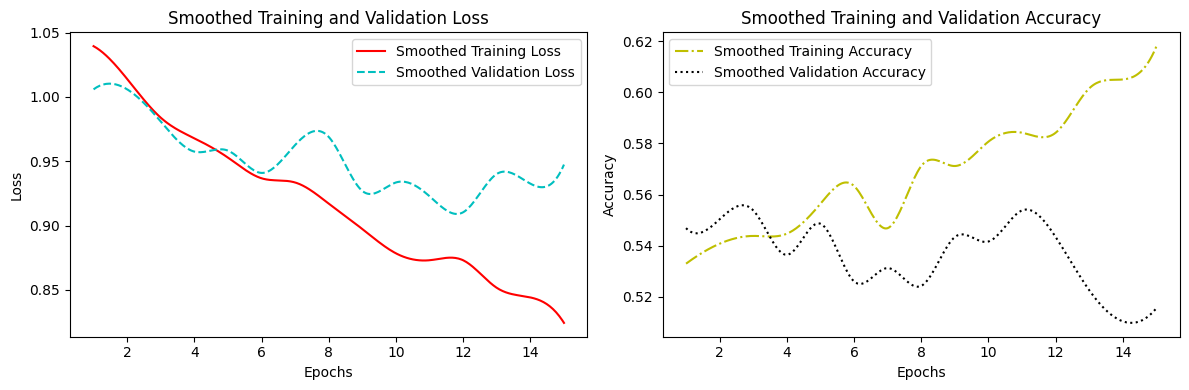

In [25]:
plot_smoothed_metrics(history['classifier_LSTM'])

In [28]:
results = evaluate_model(classifier_modelLSTM, validation_generator)

# Print the evaluation results
print("\nEvaluation Results:")
print("Precision (Weighted):", results['precision'])
print("Recall (Weighted):", results['recall'])
print("F1 (Weighted):", results['f1_weighted'])
print("F1 (Macro):", results['f1_macro'])
print("\nClassification Report:")
print(results['classification_report'])

1/1 [==============================] - 0s 422ms/step

Evaluation Results:
Precision (Weighted): 0.5157044299201162
Recall (Weighted): 0.5208333333333334
F1 (Weighted): 0.5162996675478652
F1 (Macro): 0.48374315085545677

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38       151
           1       0.50      0.40      0.44       147
           2       0.60      0.66      0.63       278

    accuracy                           0.52       576
   macro avg       0.49      0.48      0.48       576
weighted avg       0.52      0.52      0.52       576



## Hyperparameter Tunning

#### Batch Size

Batch Size Experiment:I am experimenting with different batch sizes of 8, 16, and 32 during training. The best training and validation accuracy were achieved with batch size 32. This suggests that average batch sizes of 32 allowed the model to learn more effectively, possibly by updating its weights frequently. batches size 32 can also help the model generalize better.


#### Data Augmentation

ADASYN Data oversampler:


Random oversampler:

Bert-base-uncased:

Data Augmentation: I have explored techniques for mitigating data imbalance were investigated, including Random Sampler and ADASYN Data Oversampler, yet the 'bert-base-uncased'  model stood out with remarkable efficacy. It significantly balanced the 'NONE' and 'FAVOR' stance classes, which previously had 613 and 603 samples, respectively. Moreover, the 'AGAINST' class, with 1115 samples, was also considered. By applying the BERT Paraphrasing Augmenter, the dataset was harmonized, increasing 'NONE' and 'FAVOR' from 600 to 900 samples each. This augmentation not only addressed class imbalance but also preserved contextual relevance, markedly enhancing the model's capacity to understand nuanced political language.However, the categorical  accuracy and precision reached to almost 67% and validation accuracy and precision reached to 59% respectively.


In [20]:
pip install --upgrade tensorflow

In [12]:
# from imblearn.over_sampling import ADASYN
# import pandas as pd

# # Filter training data to include only "NONE" and "FAVOR" stances
# filtered_train_df = train[train['Stance'].isin(['NONE', 'FAVOR'])]

# # Define the desired number of samples for each class
# sampling_strategy = {'NONE': 100, 'FAVOR': 100}

# # Initialize the oversampling technique (ADASYN) with sampling strategy
# oversampler = ADASYN(sampling_strategy=sampling_strategy)

# # Apply oversampling to the filtered training data
# X_resampled, y_resampled = oversampler.fit_resample(filtered_train_df[['Tweet', 'Target']], filtered_train_df['Stance'])

# # Create a new DataFrame with the resampled data
# resampled_df = pd.DataFrame({'Tweet': X_resampled[:, 0], 'Target': X_resampled[:, 1], 'Stance': y_resampled})


In [21]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.5 MB/s eta 0:00:00


In [22]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00


In [30]:
train=  create_dataset(train_df, batch_size=32, shuffle_buffer_size=None)
train

,Tweet,Target,Stance
0,those are nt pantsuits they are camouflage out...,Hillary Clinton,AGAINST
1,so christian s without beaches what is your go...,Climate Change is a Real Concern,FAVOR
2,aramisfraino pamnsc thank you so much for favs...,Hillary Clinton,NONE
3,the last thing australia or the world needs ar...,Climate Change is a Real Concern,FAVOR
4,most people need love and acceptance a lot mor...,Atheism,AGAINST
...,...,...,...
2326,marieclaire or she s a grown century woman who...,Feminist Movement,FAVOR
2327,another scotus decision i do not agree with it...,Legalization of Abortion,NONE
2328,re last i ca nt get past this why must abortio...,Legalization of Abortion,AGAINST
2329,askrobertredford beyond the national level wha...,Climate Change is a Real Concern,FAVOR


In [31]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
filtered_train_df = train[train['Stance'].isin(['NONE', 'FAVOR'])]
filtered_train_df

,Tweet,Target,Stance
1,so christian s without beaches what is your go...,Climate Change is a Real Concern,FAVOR
2,aramisfraino pamnsc thank you so much for favs...,Hillary Clinton,NONE
3,the last thing australia or the world needs ar...,Climate Change is a Real Concern,FAVOR
5,but is nt that the problem then not enough fai...,Legalization of Abortion,NONE
8,notabarrister scrufflove pfft we re getting th...,Climate Change is a Real Concern,NONE
...,...,...,...
2324,nzstuffbusiness time to change the government ...,Climate Change is a Real Concern,FAVOR
2325,arieelrosee nataliaxmoreno well you are right ...,Feminist Movement,NONE
2326,marieclaire or she s a grown century woman who...,Feminist Movement,FAVOR
2327,another scotus decision i do not agree with it...,Legalization of Abortion,NONE


In [26]:
import pandas as pd
import nlpaug.augmenter.word as naw
# Initialize the paraphrasing augmenter
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

# Oversampling factor (adjust as needed)
oversampling_factor = 1

# Create a new DataFrame for oversampled data
oversampled_data = []

desired_samples = 740

# Create a new DataFrame for oversampled data
oversampled_data = []

for _, row in filtered_train_df.iterrows():
    tweet = row['Tweet']
    target = row['Target']
    stance = row['Stance']

    # Determine the number of samples to generate based on the desired count
    if stance == 'NONE' and len(oversampled_data) < desired_samples:
        samples_to_generate = min(desired_samples - len(oversampled_data), oversampling_factor)
    elif stance == 'FAVOR' and len(oversampled_data) < desired_samples:
        samples_to_generate = min(desired_samples - len(oversampled_data), oversampling_factor)
    else:
        samples_to_generate = 0

    # Apply paraphrasing augmentation to generate new samples
    augmented_tweets = [aug.augment(tweet) for _ in range(samples_to_generate)]

    for augmented_tweet in augmented_tweets:
        oversampled_data.append({'Tweet': augmented_tweet, 'Target': target, 'Stance': stance})

# Create a DataFrame from the oversampled data
oversampled_df = pd.DataFrame(oversampled_data)
# # Print the final DataFrame with oversampled data
oversampled_df
# print(final_df)

,Tweet,Target,Stance
0,[absolutely fucking sick thinking of the other...,Atheism,FAVOR
1,[unlike other related groundwater channels har...,Atheism,NONE
2,[imagine a species first had split the atom an...,Atheism,FAVOR
3,[i ask nt for you the hereafter i know in you ...,Atheism,FAVOR
4,[sometimes it feels some broken bond that sets...,Atheism,NONE
...,...,...,...
735,[chapter two at realdonaldtrump i tuff like bo...,Donald Trump,FAVOR
736,[mexico sucks what other conclusion is there t...,Donald Trump,NONE
737,[maybe any more scheduled stops in alaska anyt...,Donald Trump,FAVOR
738,[the foxnews online publication run together w...,Donald Trump,FAVOR


In [29]:
# # oversampled_df['Stance'].unique()
# # oversampled_df['Stance'].value_counts()

oversampled_df.to_csv('/content/drive/MyDrive/COSC2779/Sassignment/StanceDataset/oversampled_df4.csv', index= False)


In [37]:
oversampled= pd.read_csv('oversampled_df4.csv', sep=',')
oversampled['Stance'].unique()

oversampled['Stance'].value_counts()

NONE     398
FAVOR    396
Name: Stance, dtype: int64

In [130]:
combined_df= pd.concat([train, oversampled], ignore_index=True)

batch_size=32
# max_sequence_length = 50
training_generator = DataGenerator(combined_df, batch_size=batch_size, n_classes=3, shuffle = True)
validation_generator =DataGenerator(val_df, batch_size=batch_size, n_classes=3, shuffle = True)
combined_df

,Tweet,Target,Stance
0,those are nt pantsuits they are camouflage out...,Hillary Clinton,AGAINST
1,so christian s without beaches what is your go...,Climate Change is a Real Concern,FAVOR
2,aramisfraino pamnsc thank you so much for favs...,Hillary Clinton,NONE
3,the last thing australia or the world needs ar...,Climate Change is a Real Concern,FAVOR
4,most people need love and acceptance a lot mor...,Atheism,AGAINST
...,...,...,...
3120,['and one typically popularly used for unknown'],Legalization of Abortion,NONE
3121,['politicspizza rebeccahlouise move from being...,Legalization of Abortion,FAVOR
3122,['some people say not willing for a child or s...,Legalization of Abortion,FAVOR
3123,['i nt you someday want to see our internation...,Hillary Clinton,FAVOR


In [90]:
for batch in training_generator:
  x, y = batch
  tweet_shape = x['tweet'].shape
  target_shape = x['target'].shape
  stance_shape = y.shape

  print(f'Tweet Shape: {tweet_shape}, Target Shape: {target_shape}, Stance Shape: {stance_shape}')


Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: (32, 3)
Tweet Shape: (32,), Target Shape: (32,), Stance Shape: 

In [131]:
# l2_lambda=0.01
# classifier_modelaug = build_classifier_model(l2_lambda=l2_lambda)

from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import EarlyStopping


l2_lambda=0.01
classifier_modelaug = build_classifier_modelLSTM(l2_lambda=l2_lambda)


# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# metrics = tf.metrics.CategoricalAccuracy()

epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = 0.01
optimizer = Adam(learning_rate=lr_schedule)
classifier_modelaug.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=(['accuracy'], metrics.Precision())
)

In [ ]:
epochs= 15
print(f'Training model with {tfhub_handle_encoder}')

history={}
history['aug_classifier'] = classifier_modelaug.fit(x=training_generator,
                               validation_data=validation_generator,

                               epochs=epochs)
                              #  callbacks=[early_stopping])

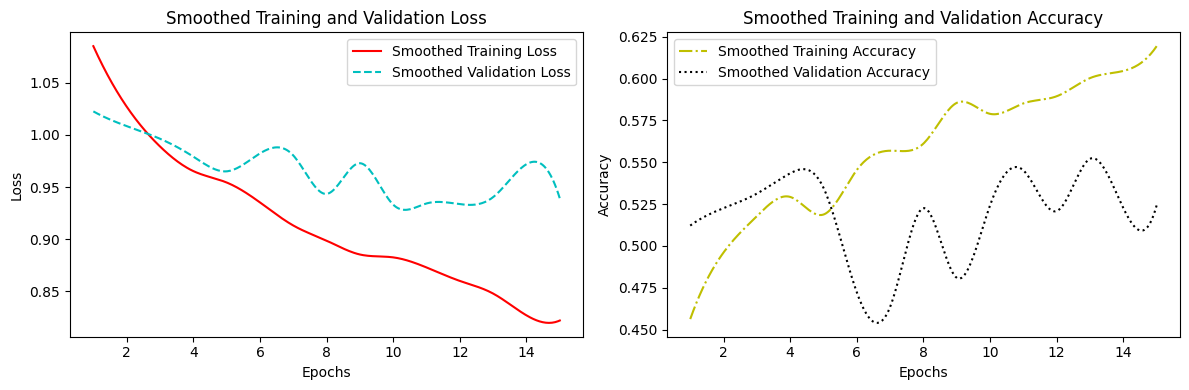

In [34]:
plot_smoothed_metrics(history["aug_classifier"])

In [39]:
results = evaluate_model(classifier_modelaug, test_generator)

# Print the evaluation results
print("\nEvaluation Results:")
print("Precision (Weighted):", results['precision'])
print("Recall (Weighted):", results['recall'])
print("F1 (Weighted):", results['f1_weighted'])
print("F1 (Macro):", results['f1_macro'])
print("\nClassification Report:")
print(results['classification_report'])

1/1 [==============================] - 0s 446ms/step

Evaluation Results:
Precision (Weighted): 0.5574252255978428
Recall (Weighted): 0.5153688524590164
F1 (Weighted): 0.520698106457258
F1 (Macro): 0.49125606061547905

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.64      0.47       489
           1       0.48      0.35      0.41       451
           2       0.68      0.53      0.60      1012

    accuracy                           0.52      1952
   macro avg       0.51      0.51      0.49      1952
weighted avg       0.56      0.52      0.52      1952



#### Learning Rate

In [38]:
learning_rates = [0.01, 0.001, 0.0001]

#### optimizer Choice

In [97]:
from sklearn.utils import validation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Nadam, Adadelta

from tensorflow.keras import metrics
f1_scores = {}
history={}
optimizers = [RMSprop(learning_rate=0.001),
    SGD(learning_rate=0.001, momentum=0.9),
    Adam(learning_rate=0.001),
    # RMSprop(learning_rate=0.001)
    ]
learning_rates = [0.01, 0.001, 0.0001]
l2_lambda=0.005
for optimizer in optimizers:
  classifier_modelLSTM = build_classifier_modelLSTM(l2_lambda=l2_lambda)
  epochs = 10
  classifier_modelLSTM.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision()]
  )
  # print(f'Training model with {tfhub_handle_encoder}')

  history['classifier_LR'] = classifier_modelLSTM.fit(x=training_generator,
                               validation_data=validation_generator,
                               epochs=epochs)

  f1_scores[optimizer] = evaluate_model(classifier_modelLSTM,validation_generator)

Epoch 1/10
97/97 [==============================] - 106s 944ms/step - loss: 1.0645 - accuracy: 0.4394 - precision_13: 0.5146 - val_loss: 1.0061 - val_accuracy: 0.5503 - val_precision_13: 0.6602
Epoch 2/10
97/97 [==============================] - 91s 945ms/step - loss: 1.0194 - accuracy: 0.4820 - precision_13: 0.5733 - val_loss: 0.9914 - val_accuracy: 0.5104 - val_precision_13: 0.6348
Epoch 3/10
97/97 [==============================] - 92s 953ms/step - loss: 0.9876 - accuracy: 0.5035 - precision_13: 0.5937 - val_loss: 0.9769 - val_accuracy: 0.4948 - val_precision_13: 0.5629
Epoch 4/10
97/97 [==============================] - 93s 958ms/step - loss: 0.9634 - accuracy: 0.5209 - precision_13: 0.6196 - val_loss: 1.0572 - val_accuracy: 0.4340 - val_precision_13: 0.5215
Epoch 5/10
97/97 [==============================] - 93s 959ms/step - loss: 0.9497 - accuracy: 0.5319 - precision_13: 0.6182 - val_loss: 0.9768 - val_accuracy: 0.5139 - val_precision_13: 0.6507
Epoch 6/10
97/97 [================

In [98]:
for optimizer_name, scores in f1_scores.items():
    print(f"Optimizer: {optimizer_name}")
    print(f"Recall (Weighted): {scores['recall']}")
    print(f"Precision(weighted):{scores['precision']}")
    print(f"F1 (Weighted): {scores['f1_weighted']}")
    print(f"F1 (Macro): {scores['f1_macro']}")
    print("\nClassification Report:")
    print(scores['classification_report'])

Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x792e88e3edd0>
Recall (Weighted): 0.5260416666666666
Precision(weighted):0.5375509734906139
F1 (Weighted): 0.5299270702897085
F1 (Macro): 0.5025962285338925

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.42      0.43       150
           1       0.42      0.50      0.46       149
           2       0.66      0.60      0.63       277

    accuracy                           0.53       576
   macro avg       0.50      0.51      0.50       576
weighted avg       0.54      0.53      0.53       576

Optimizer: <keras.src.optimizers.sgd.SGD object at 0x792e28957a30>
Recall (Weighted): 0.5416666666666666
Precision(weighted):0.48747475356981096
F1 (Weighted): 0.4558919691010399
F1 (Macro): 0.3870857245016537

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.05      0.09       151
           1       0.53      0.29  

#### Regularization

In [132]:
lambda_vals = [0.05, 0.01 0.005, 0.001]


from tensorflow.keras import metrics
b_history= {}
for reg_lambda in lambda_vals:
  classifier_modelReg = build_classifier_modelLSTM(l2_lambda= reg_lambda)
  epochs = 10
  classifier_modelReg.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision()]
  )
  b_history['classifier_Reg'+ '_h'+ str(reg_lambda)] = classifier_modelReg.fit(x=training_generator,
                               validation_data=validation_generator,
                               epochs=epochs)

Epoch 1/10
97/97 [==============================] - 108s 955ms/step - loss: 1.1888 - accuracy: 0.4417 - precision_23: 0.5344 - val_loss: 1.1313 - val_accuracy: 0.4444 - val_precision_23: 0.7692
Epoch 2/10
97/97 [==============================] - 93s 957ms/step - loss: 1.0661 - accuracy: 0.4623 - precision_23: 0.5542 - val_loss: 1.0498 - val_accuracy: 0.5069 - val_precision_23: 0.6132
Epoch 3/10
97/97 [==============================] - 94s 972ms/step - loss: 1.0202 - accuracy: 0.4797 - precision_23: 0.5552 - val_loss: 0.9849 - val_accuracy: 0.5347 - val_precision_23: 0.6018
Epoch 4/10
97/97 [==============================] - 94s 972ms/step - loss: 1.0057 - accuracy: 0.4874 - precision_23: 0.5807 - val_loss: 0.9820 - val_accuracy: 0.5226 - val_precision_23: 0.6267
Epoch 5/10
97/97 [==============================] - 94s 973ms/step - loss: 0.9892 - accuracy: 0.5013 - precision_23: 0.5909 - val_loss: 0.9974 - val_accuracy: 0.5000 - val_precision_23: 0.6250
Epoch 6/10
97/97 [================

In [133]:
for reg_lambda, history in b_history.items():
    print("\n")
    print(f"Regularization Strength (lambda): {reg_lambda}")
    print("Train loss:", history.history['loss'])
    print("Validation loss:", history.history['val_loss'])
    print("Train accuracy (emotion_output):", history.history['accuracy'])
    print("Validation accuracy (emotion_output):", history.history['val_accuracy'])



Regularization Strength (lambda): classifier_Reg_h0.05
Train loss: [1.1887602806091309, 1.0661123991012573, 1.020201325416565, 1.005728840827942, 0.9891751408576965, 0.9838973879814148, 0.9758172631263733, 0.9696167707443237, 0.9619342684745789, 0.9553555250167847]
Validation loss: [1.131346583366394, 1.0498478412628174, 0.9849305748939514, 0.9820368885993958, 0.9974190592765808, 0.9753167033195496, 1.0028696060180664, 0.9587420225143433, 1.012608528137207, 0.9610236287117004]
Train accuracy (emotion_output): [0.4416881501674652, 0.4623067080974579, 0.4797036051750183, 0.48743557929992676, 0.501288652420044, 0.5080541372299194, 0.5038659572601318, 0.5167526006698608, 0.5215850472450256, 0.53125]
Validation accuracy (emotion_output): [0.4444444477558136, 0.5069444179534912, 0.5347222089767456, 0.5225694179534912, 0.5, 0.515625, 0.4861111044883728, 0.5347222089767456, 0.5086805820465088, 0.5208333134651184]


Regularization Strength (lambda): classifier_Reg_h0.01
Train loss: [1.0864940

## Final Model: Bert Embedding with LSTM

I am  incorporating bidirectional Long Short-Term Memory (LSTM) layers, further enhancing the model's ability to capture contextual information and nuances in text. In addition to this, I leveraged the power of Google's 'talkheads_ggelu_bert_en_base' pre-trained BERT embeddings for tweet and target text processing.


In [100]:
import tensorflow as tf
import tensorflow_hub as hub

def build_classifier_modelLSTM(l2_lambda=0.01):
    # Input Layer
    tweet_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='tweet')
    target_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='target')

    # Pre-process layers
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    tweet_encoder_inputs = preprocessing_layer(tweet_input)
    target_encoder_inputs = preprocessing_layer(target_input)

    # Bert-Encoder layers
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')#False
    tweet_outputs = encoder(tweet_encoder_inputs)
    target_outputs = encoder(target_encoder_inputs)

    # Concatenated output
    net_concatenated_outputs = tf.keras.layers.concatenate([tweet_outputs['pooled_output'], target_outputs['pooled_output']], axis=-1)

    # Reshape the input for LSTM (assuming sequence length is 32, you can adjust it)
    sequence_length = 32
    lstm_units = 264

    net_reshaped = tf.keras.layers.Reshape((sequence_length, -1))(net_concatenated_outputs)

    # Adding LSTM layers
    net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(net_reshaped)
    net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units))(net)

    # Adding dropout layer
    net = tf.keras.layers.Dropout(0.1)(net)

    # Classifier layer for stance classification
    stance_output = tf.keras.layers.Dense(128, activation='relu', name='stance_classifier')(net)

    # Additional Dense layer for stance classification with regularization
    stance_output = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='stance_classifier_output')(stance_output)

    return tf.keras.Model(inputs=[tweet_input, target_input], outputs=stance_output)


In [104]:
l2_lambda=0.01
classifier_modelLSTM = build_classifier_modelLSTM(l2_lambda=l2_lambda)

In [105]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from tensorflow.keras import metrics



# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


epochs = 40


lr_schedule = 0.001
optimizer = Adam(learning_rate=lr_schedule)#learning_rate=lr_schedule
classifier_modelLSTM.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall()]
)

In [106]:
print(f'Training model with {tfhub_handle_encoder}')
history={}
history['classifier_LSTM_Final'] = classifier_modelLSTM.fit(x=training_generator,

                               validation_data=validation_generator,
                               callbacks=[early_stopping],

                                epochs=epochs,

                                verbose=1)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/24
97/97 [==============================] - 111s 982ms/step - loss: 1.0738 - accuracy: 0.4420 - precision_18: 0.5369 - recall_10: 0.1408 - val_loss: 0.9990 - val_accuracy: 0.5278 - val_precision_18: 0.6099 - val_recall_10: 0.2986
Epoch 2/24
97/97 [==============================] - 94s 968ms/step - loss: 1.0225 - accuracy: 0.4797 - precision_18: 0.5797 - recall_10: 0.2120 - val_loss: 0.9848 - val_accuracy: 0.5556 - val_precision_18: 0.6632 - val_recall_10: 0.2222
Epoch 3/24
97/97 [==============================] - 94s 969ms/step - loss: 0.9871 - accuracy: 0.5042 - precision_18: 0.5964 - recall_10: 0.2651 - val_loss: 0.9814 - val_accuracy: 0.5069 - val_precision_18: 0.6465 - val_recall_10: 0.2413
Epoch 4/24
97/97 [==============================] - 94s 970ms/step - loss: 0.9609 - accuracy: 0.5267 - precision_18: 0.6133 - recall_10: 0.3051 - val_loss: 0.9477 - val_accuracy: 0.5278 - val_precision_18: 0.

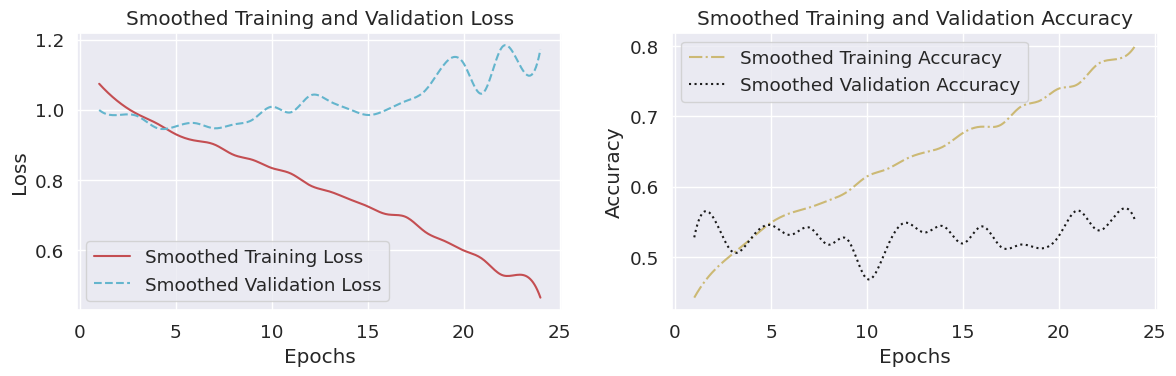

In [107]:
plot_smoothed_metrics(history["classifier_LSTM_Final"])

In [107]:
print(f'Training model with {tfhub_handle_encoder}')
history={}
history['classifier_LSTM_Final'] = classifier_modelLSTM.fit(x=training_generator,

                               validation_data=validation_generator,
                               callbacks=[early_stopping],

                                epochs=epochs,

                                verbose=1)

Training model with https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1
Epoch 1/40
97/97 [==============================] - 113s 1s/step - loss: 0.6007 - accuracy: 0.6981 - precision_8: 0.6984 - recall_2: 0.6981 - val_loss: 0.5480 - val_accuracy: 0.7535 - val_precision_8: 0.7530 - val_recall_2: 0.7517
Epoch 2/40
97/97 [==============================] - 97s 998ms/step - loss: 0.5867 - accuracy: 0.7110 - precision_8: 0.7114 - recall_2: 0.7101 - val_loss: 0.5405 - val_accuracy: 0.7535 - val_precision_8: 0.7535 - val_recall_2: 0.7535
Epoch 3/40
97/97 [==============================] - 96s 992ms/step - loss: 0.5860 - accuracy: 0.6988 - precision_8: 0.6988 - recall_2: 0.6981 - val_loss: 0.5721 - val_accuracy: 0.7274 - val_precision_8: 0.7274 - val_recall_2: 0.7274
Epoch 4/40
97/97 [==============================] - 96s 996ms/step - loss: 0.5770 - accuracy: 0.7123 - precision_8: 0.7124 - recall_2: 0.7117 - val_loss: 0.5383 - val_accuracy: 0.7448 - val_precision_8: 0.7439 - val_recall_

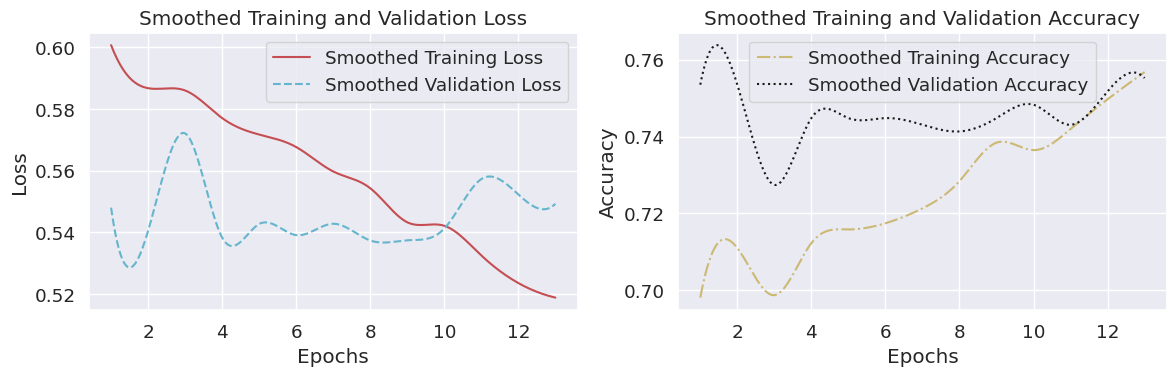

In [108]:
plot_smoothed_metrics(history["classifier_LSTM_Final"])

## Test Model Evaluation

In [115]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, test_generator):
    predictions = []  # List to store predicted labels
    true_labels = []   # List to store true labels

    # Iterate through the test generator to obtain predictions
    for x, y_true in test_generator:
        # Access the 'tweet' and 'target' inputs
        tweet_input = x['tweet']
        target_input = x['target']

        # Predict using your model
        y_pred = model.predict({'tweet': tweet_input, 'target': target_input})

        # Convert predicted probabilities to class labels (e.g., using argmax)
        # Assuming y_pred is an array of shape (batch_size, num_classes)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Append predicted labels and true labels to the lists
        predictions.extend(y_pred_labels)
        true_labels.extend(np.argmax(y_true, axis=1))  # Convert one-hot to class labels

    # Calculate evaluation metrics
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    f1_macro = f1_score(true_labels, predictions, average='macro')
    report = classification_report(true_labels, predictions)# Calculate confusion matrix
    confusion_mat = confusion_matrix(true_labels, predictions)

    return {
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'classification_report': report,
        'confusion_matrix': confusion_mat
    }



In [116]:
results = evaluate_model(classifier_modelLSTM, test_generator)


# results = evaluate_model(classifier_modelLSTM, validation_generator)
# Print the evaluation results
print("\nEvaluation Results:")
print("Precision :", results['precision'])
print("Recall :", results['recall'])
print("F1 (Weighted):", results['f1_weighted'])
print("F1 (Macro):", results['f1_macro'])
print("\nClassification Report:")
print(results['classification_report'])
# print(results['confusion_matrix'])results = evaluate_model(classifier_modelLSTM, test_generator)




1/1 [==============================] - 0s 431ms/step

Evaluation Results:
Precision : 0.5756521614691554
Recall : 0.5705128205128205
F1 (Weighted): 0.5721281094574027
F1 (Macro): 0.4938789445447007

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.41      0.37       230
           1       0.43      0.38      0.40       303
           2       0.71      0.70      0.71       715

    accuracy                           0.57      1248
   macro avg       0.49      0.50      0.49      1248
weighted avg       0.58      0.57      0.57      1248



[[ 94  45  91]
 [ 78 114 111]
 [103 108 504]]


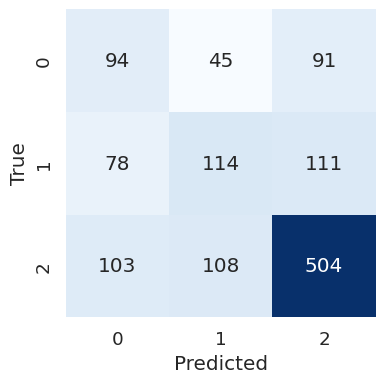

In [120]:
print(results['confusion_matrix'])
confusion_matrix= results['confusion_matrix']

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names, figsize=(4, 4)):
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example usage:
class_names = ['0', '1', '2']  # Replace with your class names
confusion_matrix = confusion_matrix# Replace with your confusion matrix

plot_confusion_matrix(confusion_matrix, class_names)
